Notebook intro: brief lab overview and execution order. Run cells top-to-bottom.

Setup: import libraries, load project modules, and initialize a Spark session.

In [1]:
import sys
import os

# Set up the path to include the src directory
sys.path.append(os.path.abspath('..'))


%load_ext autoreload
%autoreload 2

# Import our custom modules
from src.utils import get_spark_session
from src.config import API_KEY, BASE_URL, MOVIE_IDS
from src.ingestion import fetch_movie_data
from src.cleaning import clean_movie_data
from src.analysis import get_ranked_movies, analyze_franchises
from src.visualization import (
    plot_yearly_trends, 
    plot_genre_roi, 
    plot_revenue_vs_budget, 
    plot_franchise_comparison, 
    plot_popularity_vs_rating
)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark
spark = get_spark_session("TMDB_Analysis_Lab")
print(f"Spark Version: {spark.version}")

Spark Version: 3.5.0


Data ingestion: fetch movie JSON from TMDB and create a Spark DataFrame with the enforced schema.

In [2]:
# cell 2
from src.config import RAW_SCHEMA # <--- Import the new schema

# 1. Fetch raw data using Python (Driver Node)
print(f"Fetching data for {len(MOVIE_IDS)} movies...")
raw_data_list = fetch_movie_data(MOVIE_IDS, API_KEY, BASE_URL)

# 2. Convert to Spark DataFrame ENFORCING the schema
# This prevents Spark from guessing "Map" instead of "Struct"
df_raw = spark.createDataFrame(raw_data_list, schema=RAW_SCHEMA)

print("Raw Schema (Enforced):")
df_raw.printSchema()

2026-01-05 15:25:14,343 - INFO - Fetching ID 0 (Attempt 1/3)...


Fetching data for 19 movies...


2026-01-05 15:25:16,349 - WARNING - Movie ID 0 not found (404). Skipping.
2026-01-05 15:25:16,552 - INFO - Fetching ID 299534 (Attempt 1/3)...
2026-01-05 15:25:16,915 - INFO - Fetching ID 19995 (Attempt 1/3)...
2026-01-05 15:25:17,270 - INFO - Fetching ID 140607 (Attempt 1/3)...
2026-01-05 15:25:17,606 - INFO - Fetching ID 299536 (Attempt 1/3)...
2026-01-05 15:25:17,938 - INFO - Fetching ID 597 (Attempt 1/3)...
2026-01-05 15:25:18,270 - INFO - Fetching ID 135397 (Attempt 1/3)...
2026-01-05 15:25:18,605 - INFO - Fetching ID 420818 (Attempt 1/3)...
2026-01-05 15:25:18,937 - INFO - Fetching ID 24428 (Attempt 1/3)...
2026-01-05 15:25:19,275 - INFO - Fetching ID 168259 (Attempt 1/3)...
2026-01-05 15:25:19,611 - INFO - Fetching ID 99861 (Attempt 1/3)...
2026-01-05 15:25:19,953 - INFO - Fetching ID 284054 (Attempt 1/3)...
2026-01-05 15:25:20,287 - INFO - Fetching ID 12445 (Attempt 1/3)...
2026-01-05 15:25:20,621 - INFO - Fetching ID 181808 (Attempt 1/3)...
2026-01-05 15:25:21,155 - INFO - Fet

Raw Schema (Enforced):
root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- status: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- budget: long (nullable = true)
 |-- runtime: long (nullable = true)
 |-- popularity: double (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: long (nullable = true)
 |-- original_language: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- id: integer (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- p

Cleaning: run the Spark cleaning pipeline to normalize fields and compute derived metrics.

In [3]:
# cell 3
# Apply our Spark cleaning pipeline
df_clean = clean_movie_data(df_raw)

# Cache the result since we will use this dataframe for multiple analyses
df_clean.cache()

print(f"Cleaned Row Count: {df_clean.count()}")
df_clean.select("title", "release_date", "revenue_musd", "roi").show(5, truncate=False)

Cleaned Row Count: 18
+----------------------------+------------+------------+-----------------+
|title                       |release_date|revenue_musd|roi              |
+----------------------------+------------+------------+-----------------+
|Avengers: Endgame           |2019-04-24  |2799.4391   |7.86359297752809 |
|Avatar                      |2009-12-16  |2923.706026 |12.33631234599156|
|Star Wars: The Force Awakens|2015-12-15  |2068.223624 |8.441729077551022|
|Avengers: Infinity War      |2018-04-25  |2052.415039 |6.841383463333333|
|Titanic                     |1997-11-18  |2264.162353 |11.320811765     |
+----------------------------+------------+------------+-----------------+
only showing top 5 rows



Export: write raw JSON and processed CSV to the `data/` directories.

In [ ]:
# Cell: Data Export
import json
import os

# Define export paths (relative to the notebook location)
raw_path = "../data/raw/movies_raw.json"
processed_path = "../data/processed/movies_processed.csv"

# Ensure the directories exist (just in case)
os.makedirs(os.path.dirname(raw_path), exist_ok=True)
os.makedirs(os.path.dirname(processed_path), exist_ok=True)

# 1. Export Raw Data (JSON)
# We use the 'raw_data_list' variable we fetched in Cell 2
try:
    with open(raw_path, 'w') as f:
        json.dump(raw_data_list, f, indent=4)
    print(f"SUCCESS: Raw data saved to {raw_path}")
except Exception as e:
    print(f"ERROR: Could not save raw JSON. {e}")

# 2. Export Processed Data (CSV)
# We use 'df_clean' from Cell 3. 
# converting to Pandas first ensures we get a single CSV file instead of a folder of part-files.
try:
    df_clean.toPandas().to_csv(processed_path, index=False)
    print(f"SUCCESS: Processed data saved to {processed_path}")
except Exception as e:
    print(f"ERROR: Could not save processed CSV. {e}")

SUCCESS: Raw data saved to ../data/raw/movies_raw.json
SUCCESS: Processed data saved to ../data/processed/movies_processed.csv


Ranking examples: show top revenue, top ROI, and worst flops (filtered by budget).

In [4]:
# cell 4
print("--- Top 5 Highest Revenue ---")
top_rev = get_ranked_movies(df_clean, "revenue_musd", ascending=False)
top_rev.select("title", "revenue_musd", "budget_musd").show()

print("--- Top 5 Highest ROI ---")
top_roi = get_ranked_movies(df_clean, "roi", ascending=False)
top_roi.select("title", "roi", "revenue_musd").show()

print("--- Worst 5 Flops (Lowest ROI) ---")
# Filter for significant budget first to avoid divide-by-zero anomalies on micro-films
flop_roi = get_ranked_movies(df_clean.filter("budget_musd > 10"), "roi", ascending=True)
flop_roi.select("title", "roi", "budget_musd", "revenue_musd").show()

--- Top 5 Highest Revenue ---
+--------------------+------------+-----------+
|               title|revenue_musd|budget_musd|
+--------------------+------------+-----------+
|              Avatar| 2923.706026|      237.0|
|   Avengers: Endgame|   2799.4391|      356.0|
|             Titanic| 2264.162353|      200.0|
|Star Wars: The Fo...| 2068.223624|      245.0|
|Avengers: Infinit...| 2052.415039|      300.0|
+--------------------+------------+-----------+

--- Top 5 Highest ROI ---
+--------------------+-----------------+------------+
|               title|              roi|revenue_musd|
+--------------------+-----------------+------------+
|              Avatar|12.33631234599156| 2923.706026|
|             Titanic|     11.320811765| 2264.162353|
|      Jurassic World|      11.14358296| 1671.537444|
|Harry Potter and ...|     10.732089752| 1341.511219|
|           Frozen II|9.691223173333332| 1453.683476|
+--------------------+-----------------+------------+

--- Worst 5 Flops (Lowes

Franchise analysis: aggregate and compare franchise vs standalone performance.

In [5]:
# cell 5
# Compare Franchises vs Standalone
franchise_stats = analyze_franchises(df_clean)

# Collect to Pandas for display
pdf_franchise = franchise_stats.toPandas()
display(pdf_franchise)

,is_franchise,count,avg_revenue,median_roi,avg_budget,avg_popularity,avg_rating
0,True,16,1682.668411,7.786117,218.0,24.937344,7.3895
1,False,2,1765.139159,9.617018,180.0,26.097350,7.4510


Prepare visualization datasets: yearly, genre, scatter, and franchise aggregates, then convert to Pandas.

In [ ]:
# Cell 6: Data Preparation for Visualizations
from pyspark.sql.functions import year, explode, split, col, median, mean, count
import pyspark.sql.functions as F  # <--- FIX: This import was missing

# 1. Prepare Yearly Trends Data
# Extract year from release_date and aggregate
df_yearly = df_clean.withColumn("year", year("release_date")) \
    .groupBy("year") \
    .agg(
        count("id").alias("movie_count"),
        mean("revenue_musd").alias("mean_revenue"),
        mean("budget_musd").alias("mean_budget"),
        mean("roi").alias("mean_roi")
    ).orderBy("year")

# 2. Prepare Genre Data (Explode the 'A|B|C' string into separate rows)
df_genre = df_clean.withColumn("genre", explode(split("genres", "\|"))) \
    .groupBy("genre") \
    .agg(median("roi").alias("median_roi")) \
    .orderBy(col("median_roi").desc())

# 3. Prepare Scatter Plot Data (Individual Movies)
df_scatter = df_clean.select("title", "budget_musd", "revenue_musd", "popularity", "vote_average")

# 4. Prepare Franchise Data
df_franchise = df_clean.withColumn("type", 
                                   F.when(col("belongs_to_collection").isNotNull(), "Franchise")
                                   .otherwise("Standalone")) \
    .groupBy("type") \
    .agg(
        mean("revenue_musd").alias("mean_revenue"),
        mean("budget_musd").alias("mean_budget"),
        mean("roi").alias("mean_roi"),
        mean("vote_average").alias("mean_rating")
    )

# --- Collect all to Pandas ---
# These variables (pdf_...) will be passed to your visualization functions next
pdf_yearly = df_yearly.toPandas()
pdf_genre = df_genre.toPandas()
pdf_scatter = df_scatter.toPandas()
pdf_franchise = df_franchise.toPandas()

print("Data ready for visualization!")

Data ready for visualization!


Visualization: yearly trends (calls plotting helper).

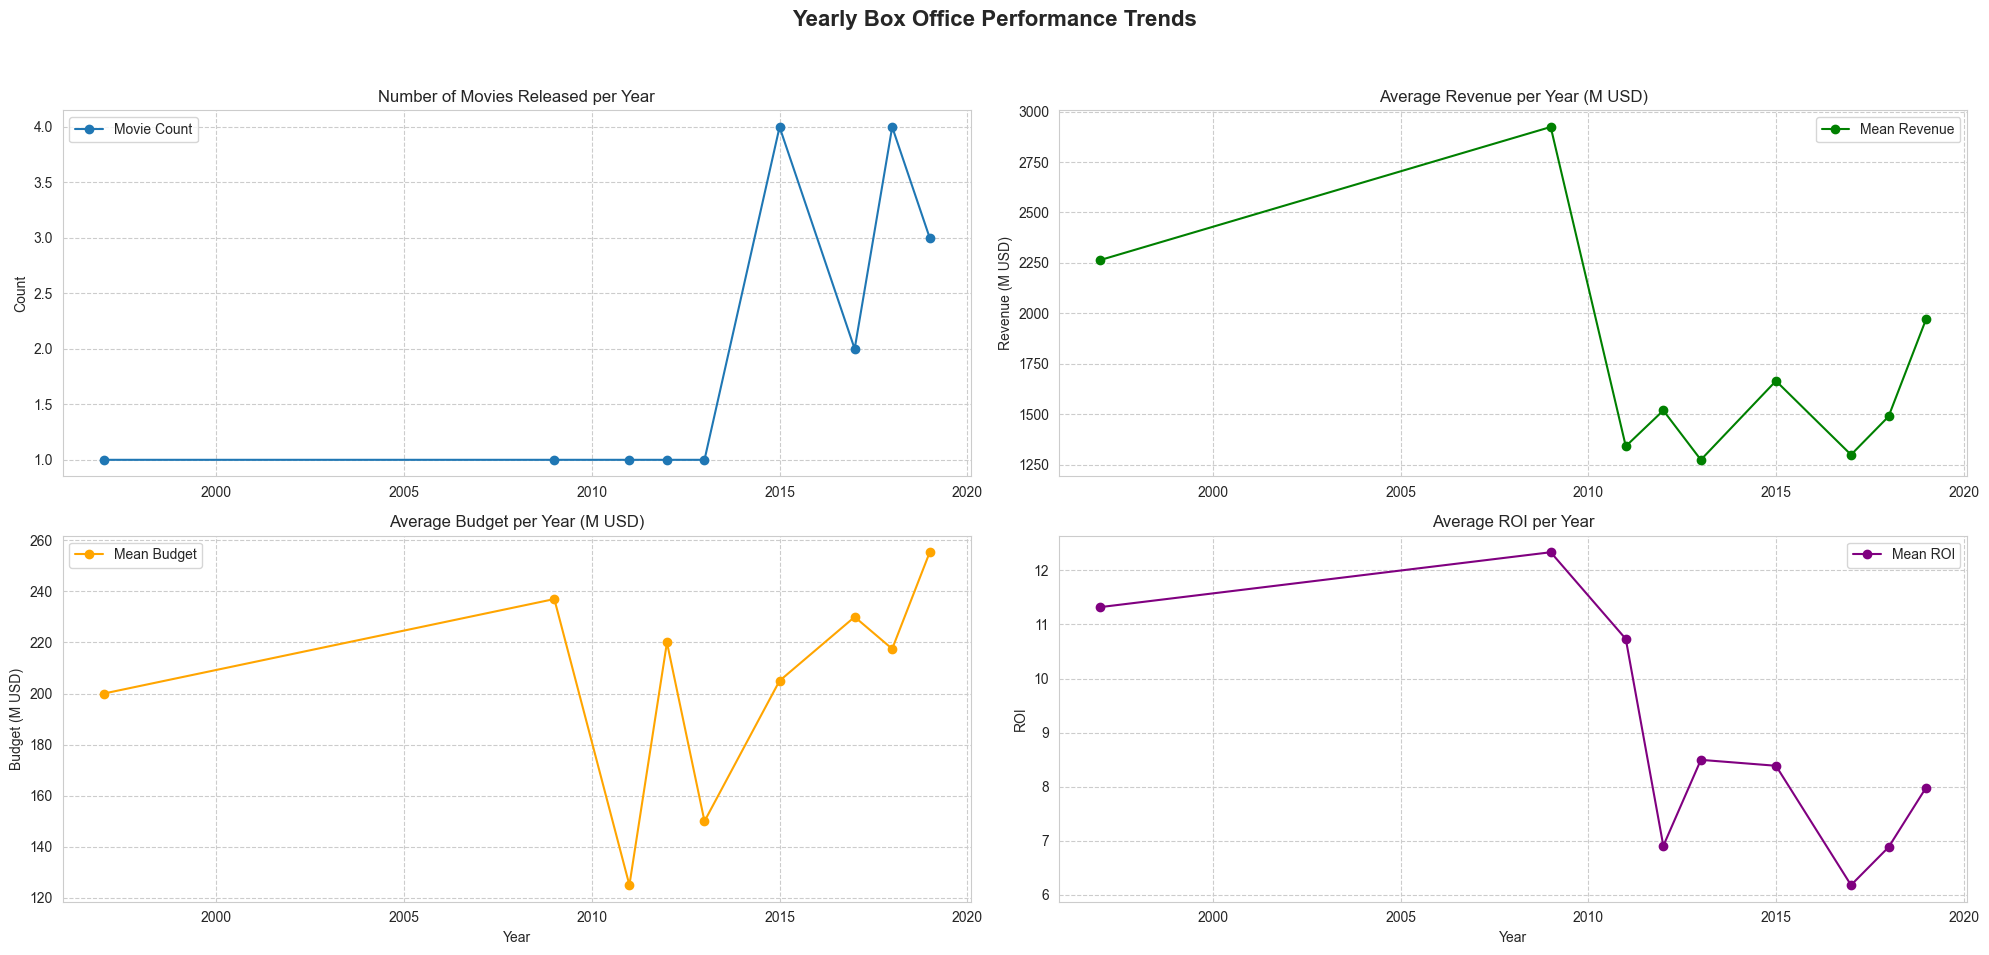

In [7]:
# Cell 7
plot_yearly_trends(pdf_yearly)

Visualization: median ROI by genre.

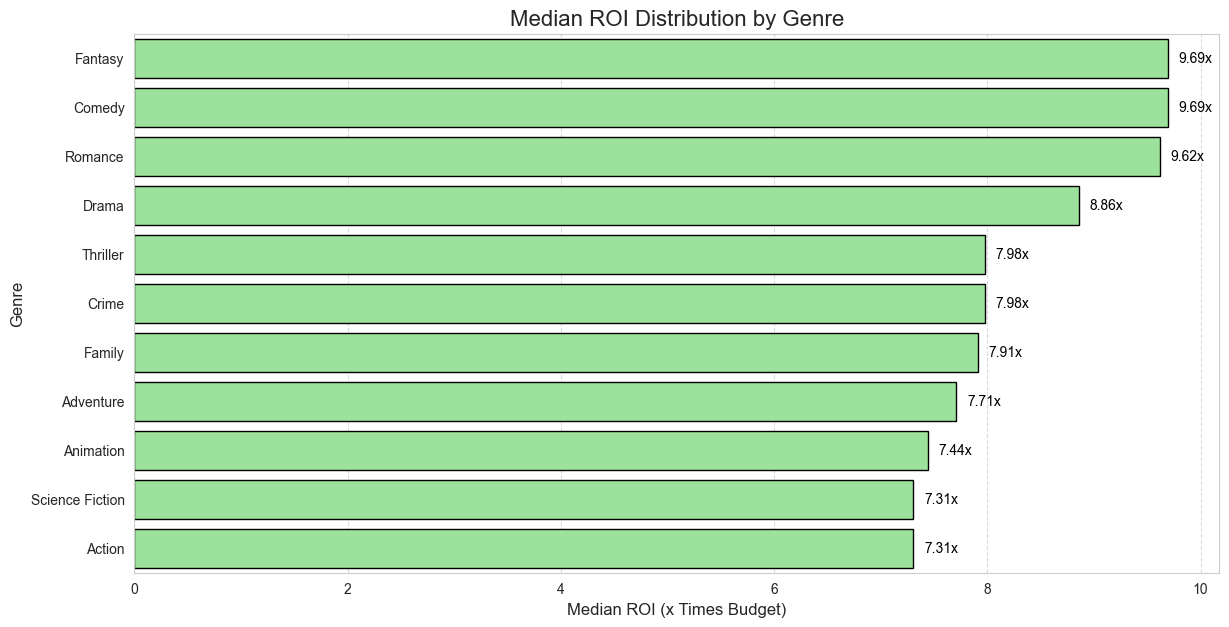

In [8]:
# Cell 8
plot_genre_roi(pdf_genre)

Visualization: scatter of revenue vs budget to identify blockbusters and flops.

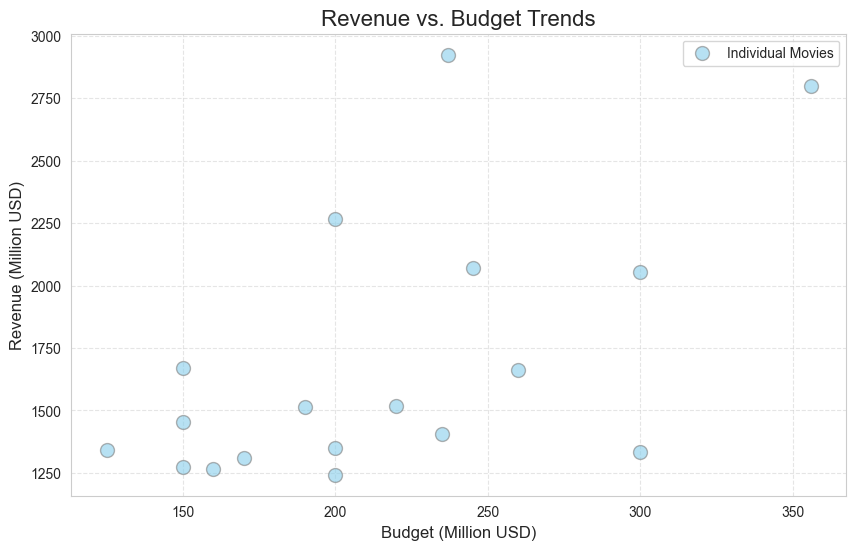

In [9]:
# Cell 9
plot_revenue_vs_budget(pdf_scatter)

Visualization: compare franchise and standalone performance.

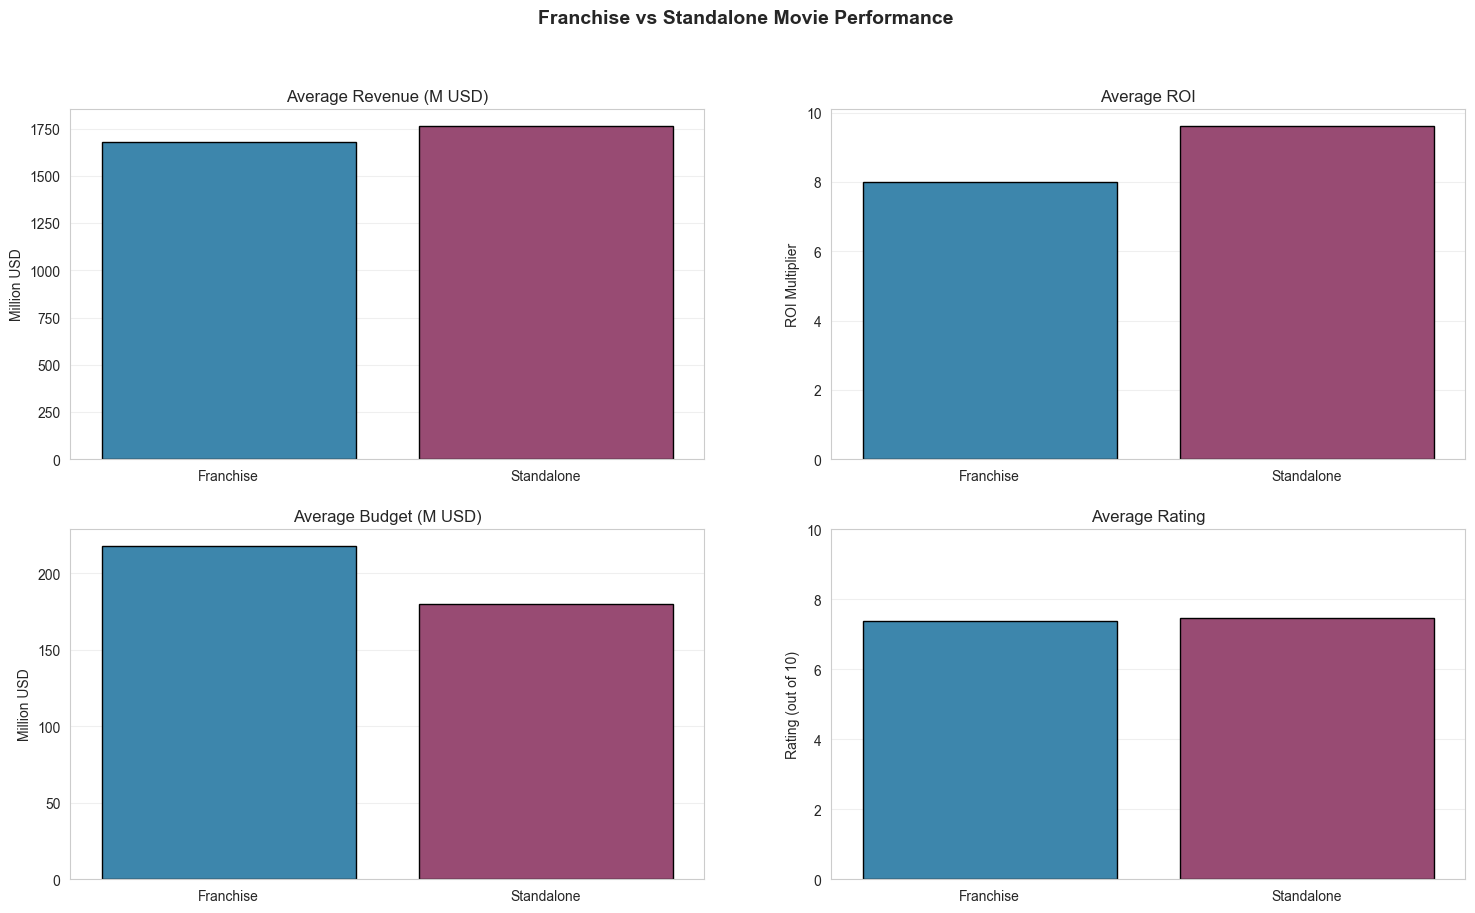

In [10]:
# Cell 10
plot_franchise_comparison(pdf_franchise)

Visualization: popularity versus average rating scatter.

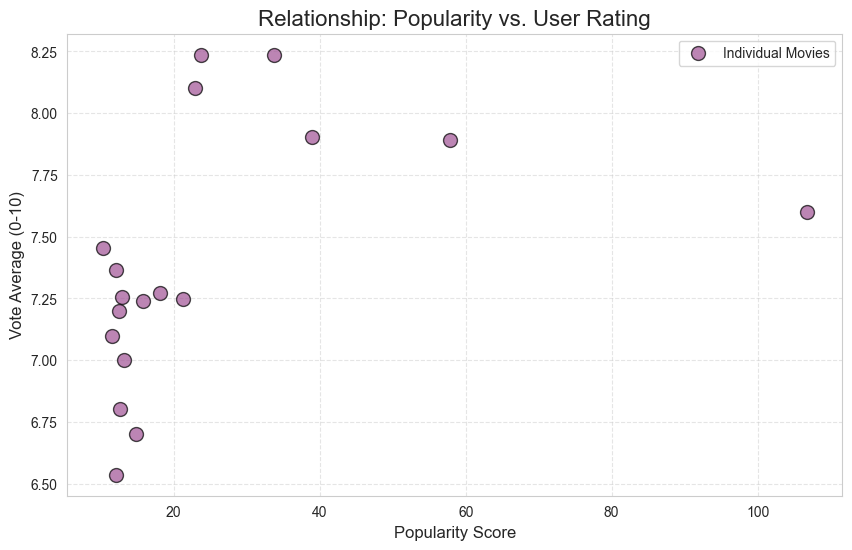

In [11]:
# Cell 11
plot_popularity_vs_rating(pdf_scatter)